In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from dgllife.utils import smiles_to_complete_graph
from functools import partial
from tdc.multi_pred import DTI
from collections import defaultdict as ddict
import os 

Using backend: pytorch


Downloading...
100%|██████████| 839M/839M [00:29<00:00, 28.0MiB/s] 
Loading...
Done!
To log space...


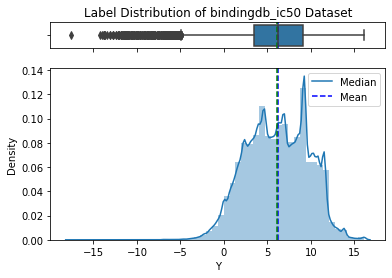

In [31]:
# Data: https://tdcommons.ai/multi_pred_tasks/dti/

data_suffix = 'IC50'
data = DTI(name = f'BindingDB_{data_suffix}')
os.makedirs(f'BindingDB_{data_suffix}', exist_ok=True)
data.convert_to_log()
data.label_distribution()

In [32]:
a = data.get_data()
if data_suffix == 'Kd':
    a = a[a['Y'] < 10]
elif data_suffix == 'Ki':
    a = a[a['Y'] < 6]
elif data_suffix == 'IC50':
    a = a[a['Y'] < 2.5]
a['Y_Target'] = a[['Y', 'Target']].values.tolist()

In [34]:
b = a[['Drug', 'Y_Target']].groupby('Drug').apply(min).reset_index(drop=True)
b[['Y', 'Target']] = b['Y_Target'].values.tolist()

targets = b['Target'].unique().tolist()
target2idx = dict(zip(targets, range(len(targets))))
idx2target = {idx: target for target, idx in target2idx.items()}
b['Target_idx'] = b['Target'].apply(lambda x: target2idx[x])

In [35]:
c = b['Target_idx'].value_counts().reset_index()

max_graphs_per_class = 100
min_graphs_per_class = 10

classes = c[c['Target_idx'] <= max_graphs_per_class][c['Target_idx'] >= min_graphs_per_class]['index'].tolist()
dataset = b[b['Target_idx'].isin(classes)]

In [37]:
np.random.shuffle(classes)

N = len(classes)
pos_classes = classes[:int(N*.9)]
neg_classes = classes[int(N*.9):]

In [38]:
train_graphs = dataset[dataset['Target_idx'].isin(pos_classes)]

In [39]:
n_pos_in_test = 1800
idxs = list(range(train_graphs.shape[0]))
np.random.shuffle(idxs)
train_dataset = train_graphs.iloc[idxs[:-n_pos_in_test]]
test_pos_graphs = train_graphs.iloc[idxs[-n_pos_in_test:]]

In [40]:
train_dataset = train_dataset[['Drug', 'Target_idx']].reset_index(drop=True)
train_dataset.columns = ['pos', 'class']
train_dataset.to_csv(f'BindingDB_{data_suffix}/train.csv', index=False)

In [41]:
test_neg_graphs = dataset[dataset['Target_idx'].isin(neg_classes)]

In [42]:
class2graphs = ddict(list)
for row in test_neg_graphs[['Target_idx', 'Drug']].values.tolist():
    class2graphs[row[0]].append(row[1])

In [43]:
num_pairs_for_each_class = 10
neg_pairs_true = []
neg_df = pd.DataFrame()
for key in class2graphs:
    neg_df = neg_df.append(pd.DataFrame(np.random.choice(class2graphs[key], size=(num_pairs_for_each_class, 2))))

neg_df.columns = ['neg', 'pos']
neg_df['class'] = 1

In [45]:
df = pd.DataFrame()
df['neg'] = test_neg_graphs.sample(620)['Drug'].reset_index(drop=True)
df['pos'] = train_graphs.sample(620)['Drug'].reset_index(drop=True)
df['class'] = 0
df

,neg,pos,class
0,CC(=O)NCCc1cccc2ccc3occc3c12,COc1ccc2c(c1)[C@]1(C[C@H]1c1ccc3c(/C=C/c4ccc(N...,0
1,O=C(O)C1CCN(C(=O)/C=C/c2ccc(Sc3ccc4c(c3)OCCO4)...,COc1cc(NC(=S)NCCCn2cncc2C)ccc1OCCCCNc1ncccn1,0
2,Cc1nc2c(c(-c3ccn[nH]3)n1)C[C@@H](C)N(C(=O)c1cc...,C=CC(=O)Nc1ccccc1Oc1nc(Nc2cnn(CCOC)c2)ncc1Cl,0
3,O=P(O)(O)C(Nc1cc(-c2ccc(OC3CC3)cc2)ccn1)P(=O)(O)O,CCCC[C@@H]1NC(=O)CC[C@@H](C(N)=O)NC(=O)[C@H](C...,0
4,Cc1ccc2c(OCC(=O)N3CCC[C@H]3C(=O)NC3CCC3)cc(C(=...,NS(=O)(=O)CCNC(=O)C(c1nc2ccc(-c3ccccc3)cc2s1)S...,0
...,...,...,...
615,O=C(c1cccc(C(F)(F)F)c1Cl)N1[C@H]2CCC[C@@H]1c1n...,CC(C)c1nc(-c2nnc3n2CCN(C(=O)c2ccc(-c4cccs4)cc2...,0
616,O=C(Nc1cc2ccccc2cc1Oc1ccc(C(=O)O)c(C(=O)O)c1)c...,O=c1[nH]c2c(O)ccc([C@@H](O)CNCCCSCCOCCc3ccccc3...,0
617,CCOC1CCN(Cc2c(OC)cc(C)c3[nH]ccc23)C(c2ccc(C(=O...,O=C(NC1COP(=O)(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3...,0
618,CNC(=O)N1CCc2c(c(Nc3cc(C(F)F)c(-c4cnn(C)c4)cc3...,COc1ccc(-c2cc(=O)c3cc(OC)c4c(OC)ccc(OC)c4c3o2)cc1,0


In [46]:
test_dataset = df.append(neg_df)
os.makedirs(f'BindingDB_{data_suffix}', exist_ok=True)
test_dataset.to_csv(f'BindingDB_{data_suffix}/test.csv', index=False)